#  Cigar data anaylisis

In [1]:
# S2 signal script
import sys
sys.path.append('/home/investigator/mariandbt/python/notebooks/modules')

from datetime import datetime
import matplotlib.dates as mdates  # Import for date formatting

from import_modules import *
import set_up as setup
import s2_simulation as s2sim

from scipy.optimize import curve_fit


import glob
import re

##  Functions

In [2]:
# Sort the files based on the number that appears right before the '.h5' extension
def extract_number_h5(file):
    # Extract the number before '.h5' using regex
    match = re.search(r'_(\d+)\.h5$', file)  # Matches '_number.h5'
    return int(match.group(1)) if match else float('inf')  # Extract the number or return 'inf'


In [3]:

CHAmp={
"CH1":535,
"CH2":537,
"CH3":684,
"CH4":675}

# Samuele's
# ConvPar={
# "CH1":(3.03e-8,-6.69e-9), # V*s
# "CH2":(3.42e-8,-6.28e-9), # V*s
# "CH3":(4.33e-8,-5.77e-9), # V*s
# "CH4":(3.98e-8,-8.78e-9)  # V*s
# }

# Marian's (20241022)
ConvPar={
"CH1":(3.26e-8,-7.32e-9), # V*s
"CH2":(3.79e-8,-1.06e-8), # V*s
"CH3":(4.44e-8,-1.03e-8), # V*s
"CH4":(4.13e-8,-1.07e-8)  # V*s
}

def ChargeToPes(integral, p0, p1):
    
#     integral is in V*us
    
    photoelectrons = (integral*1e-6 - p1) / p0
    return photoelectrons

# charge_in_pes = ChargeToPes(charge_in_Vus[f'CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

In [4]:
def print_wvf(event_df, title = None, channel = all):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

    font_size = 20
    
    t = event_df.TIME # [s]
    t = t*1e6 # [us]
    
    if channel == all:
        for i in [1, 2, 3, 4]:

            ch = event_df[f'CH{i}'] # [V]
            ax.plot(t, ch, label = f'CH{i}')
    else:
        ch = event_df[f'CH{channel}'] # [V]
        ax.plot(t, ch, label = f'CH{channel}')
        
    if title == None:
        title = f'Event nº {int(event_df.event.mean())}'

    ax.set_title(f'{title}; run {run}', fontsize = font_size);
    ax.set_xlabel(r'Time [$\mu$s]', fontsize = font_size);
    ax.set_ylabel('Signal [V]', fontsize = font_size);
    
    return ax

In [5]:
def BaselineAndPeakCorrection(event_df):
    
    t = event_df.TIME # [s]

    corrected_df = {'event': event_df.event, 'TIME': t}
    
    #Baseline correction
    # Loop over all columns in the dataframe that start with 'CH'
    for ii in event_df.columns:
        if ii.startswith('CH'):
            ch = event_df[f'{ii}'] # [V]

#             offset = ch[t < -1.5*1e-6].mean()
            offset = 0

            ch = ch - offset

            corrected_df[f'{ii}'] = ch
        
    corrected_df = pd.DataFrame(corrected_df).reset_index(drop=True)
        
    # Peak correction
    # Replace np.inf with NaN
    corrected_df = corrected_df.replace(np.inf, np.nan)
    corrected_df = corrected_df.replace(np.nan, corrected_df.max())
    corrected_df = corrected_df.replace(-np.inf, np.nan)
    corrected_df = corrected_df.replace(np.nan, corrected_df.min())
    
    return corrected_df

In [6]:
def sum_of_gaussians(x, *params):
    """
    Returns the sum of multiple Gaussian functions with normalization.
    
    Parameters:
    x : array-like
        Points at which to evaluate the function.
    *params : list
        Flattened list containing amplitudes, means, and standard deviations.
    
    Returns:
    result : array-like
        The sum of all normalized Gaussians evaluated at points x.
    """
    num_gaussians = len(params) // 3  # Each Gaussian has A, mu, sigma
    A = np.array(params[:num_gaussians])
    mu = np.array(params[num_gaussians:2*num_gaussians])
    sigma = np.array(params[2*num_gaussians:])

    result = np.zeros_like(x)
    for a, m, s in zip(A, mu, sigma):
        gaussian = (a / (s * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - m) / s) ** 2)
        result += gaussian
    
    return result

In [7]:
def gaussian(t, mu, sigma):
    """Define a Gaussian function."""
    return (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((t - mu) / sigma) ** 2)

def convolution_model(t, t0, rise, tau, mu, sigma):
    """Convolution between s2sim.ResponseSiPM and a Gaussian."""
    dt = t[1] - t[0]  # Assuming uniform spacing in t
    response = s2sim.ResponseSiPM(df_area, t, t0, rise, tau, baseline)
    gauss = gaussian(t, mu, sigma)
    
    # Perform convolution
    convolved = np.convolve(response, gauss, mode='same')*dt
    return convolved

def fit_function(t, t0, rise, tau, mu, sigma):
    """Function to fit to the data."""
    return convolution_model(t, t0, rise, tau, mu, sigma)

In [8]:
# Define a function to calculate the integral and return a DataFrame
def calculate_integral(group):
    
    corrected_df = BaselineAndPeakCorrection(group)  
    
    t = corrected_df.TIME # [s]
    t = t*1e6 # [us]  
    
    tau = {'CH1': 193.37,
           'CH2': 178.7,
           'CH3': 129.86,
           'CH4': 207.92
          } # [ns] SINGLE PHOTON
    
    
    integrals = {}
    # Loop over all columns in the dataframe that start with 'CH'
    for ch in corrected_df.columns:
        if ch.startswith('CH'):
            
#             tau_in_us = tau[ch]*1e-3 # [us]
            tau_in_us = 9*1e3*1e-3 # [us]
            time_window = t < tau_in_us*4
        
            integrals[f'charge_{ch}'] = np.trapz(corrected_df[ch][time_window], t[time_window])

    # Convert the integrals dictionary to a DataFrame
    return pd.DataFrame([integrals])

In [9]:
# Function to shift waveforms so peak (max y) is at x=0
def ShiftWaveformToPeak(event_df):
    
    # Common x-axis based on the original time from event_df
    t = np.array(event_df.TIME) # [s]

    shifted_df = {'event': event_df.event, 'TIME': t}
    
    # Loop over all columns in the dataframe that start with 'CH'
    for channel in event_df.columns:
        if channel.startswith('CH'):
            ch = np.array(event_df[f'{channel}']) # [V]

            peak_idx = np.argmax(ch)  # Index of max y-value
            t_peak = t[peak_idx]     # Corresponding x-value of the peak
            t_shifted = t - t_peak   # Shift x-values so that peak is at x=0

            # Initialize a new array for y-values on the common x-axis, filling with zeros
            aligned_y = np.zeros_like(t)
            # Interpolate or shift y-values onto the common axis
            # Use np.interp to interpolate shifted y-values onto the common x-axis, filling gaps with 0s
            aligned_y = np.interp(t, t_shifted, ch, left=ch[0], right=ch[-1])


            shifted_df[f'{channel}'] = aligned_y
        
    shifted_df = pd.DataFrame(shifted_df).reset_index(drop=True)
        
    return shifted_df

##  Data reading

In [10]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20240926_cigar'

In [11]:
# run      = '20240908_no_source_3.5bar' # 50 files
# run      = '20240925_with_co_3.5bar_nitrogen_20.5deg_no_amp' # 33 files
run      = '20241011_with_am_2.5bar_N_14.0deg_no_amp' # 34 files
# run      = '20241016_with_am_4.5bar_Ar_14.0deg_single_photon_CH1_amp' # 3 files
# run      = '20241016_with_am_4.5bar_Ar_14.0deg_single_photon_CH2_amp' # 3 files
# run      = '20241016_with_am_4.5bar_Ar_14.0deg_single_photon_CH3_amp' # 3 files
# run      = '20241016_with_am_4.5bar_Ar_14.0deg_single_photon_CH4_amp' # 3 files
# run      = '20241017_with_am_5.5bar_Ar_14.0deg_no_amp' # 38 files
# run      = '20241011_with_am_3.5bar_N_14.0deg_no_amp' # 50 files


run_path = os.path.join(path, run) 

n_files = 50

selected_run = 0

run_file = os.path.join(run_path, f"{run}_{selected_run}.h5")

In [12]:
setup.check_h5(run_file)

/home/investigator/mariandbt/python/data/20240926_cigar/20241011_with_am_2.5bar_N_14.0deg_no_amp/20241011_with_am_2.5bar_N_14.0deg_no_amp_0.h5 (File) ''
Last modif.: '2024-10-15T12:55:06+00:00'
Object Tree: 
/ (RootGroup) ''
/data (Group) ''
/data/table (Table(12500000,)) ''



##  Waveform

In [13]:
run_data = pd.read_hdf(run_file)

In [14]:
run_df = run_data.copy()

In [16]:
# run_df

In [25]:
event = 163
event_df = run_df.groupby('event').get_group(event)

In [26]:
event_df

,TIME,CH1,CH2,CH3,CH4,event
1018750,-0.000002,0.000086,0.000344,-0.000127,0.000434,163
1018751,-0.000002,0.000027,0.000244,-0.000047,0.000453,163
1018752,-0.000002,0.000034,0.000184,-0.000125,0.000320,163
1018753,-0.000002,0.000052,0.000152,-0.000108,0.000277,163
1018754,-0.000002,0.000108,0.000348,0.000045,0.000412,163
...,...,...,...,...,...,...
1024995,0.000008,0.000206,0.000245,-0.000031,0.000002,163
1024996,0.000008,0.000180,0.000295,-0.000031,0.000072,163
1024997,0.000008,0.000245,0.000338,-0.000034,0.000081,163
1024998,0.000008,0.000212,0.000264,-0.000122,0.000042,163


###  Raw waveform

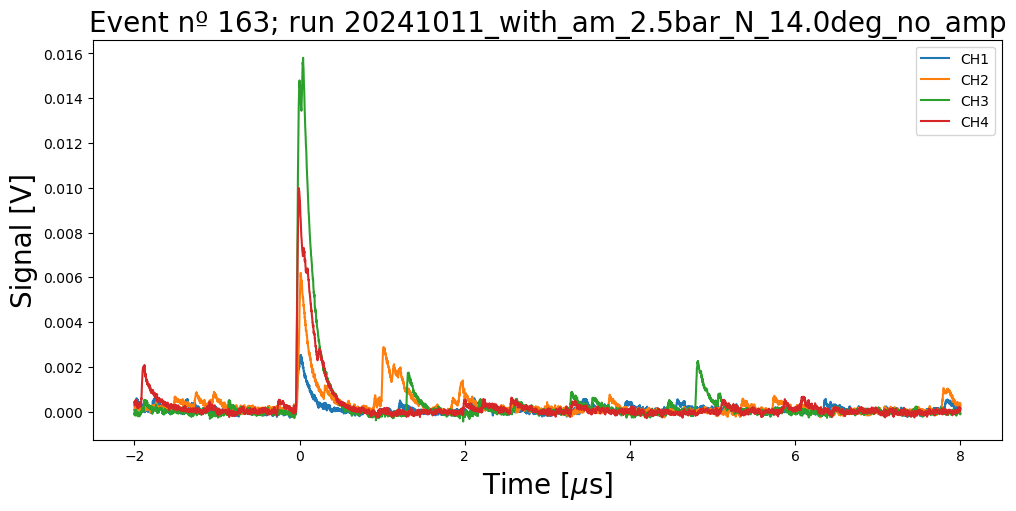

In [27]:
ax = print_wvf(event_df, channel = all)

ax.legend(loc = 'best')
# ax.set_xlim(-1.5, 1)
# ax.set_ylim(-0.001, 0.001)


###  Baseline correction

In [31]:
corrected_df = BaselineAndPeakCorrection(event_df)

In [32]:
event_df.CH2[event_df.TIME < -1*1e-6]

350000    0.000303
350001    0.000161
350002    0.000138
350003    0.000202
350004    0.000200
            ...   
350620    0.033231
350621    0.032866
350622    0.032531
350623    0.031961
350624    0.031497
Name: CH2, Length: 625, dtype: float64

In [33]:
event_df.CH2[event_df.TIME < -0.02*1e-6].mean()

0.006238816387318253

In [34]:
corrected_df.CH1.max(), event_df.CH1.max()

(0.0137680575, 0.015296875)

(-2.0, 0.06)

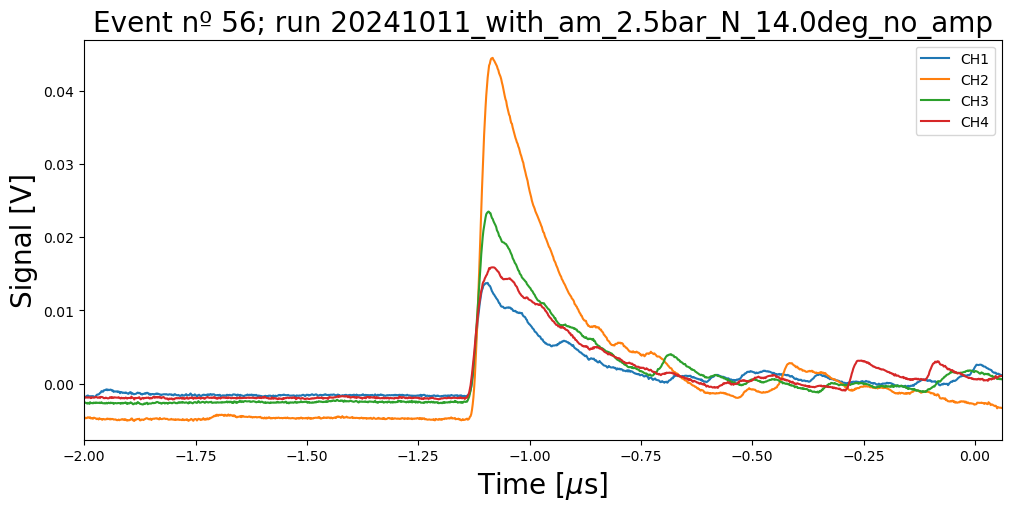

In [37]:
ax = print_wvf(corrected_df, channel = all)

ax.legend(loc = 'best')

ax.set_xlim(-2, 0.06)
# ax.set_ylim(-0.001, 0.001)


###  Shifted to center

In [118]:
channel = 2

In [35]:
shifted_df = ShiftWaveformToPeak(event_df)

In [36]:
shifted_df.CH2.min()

-0.00035180175781250226

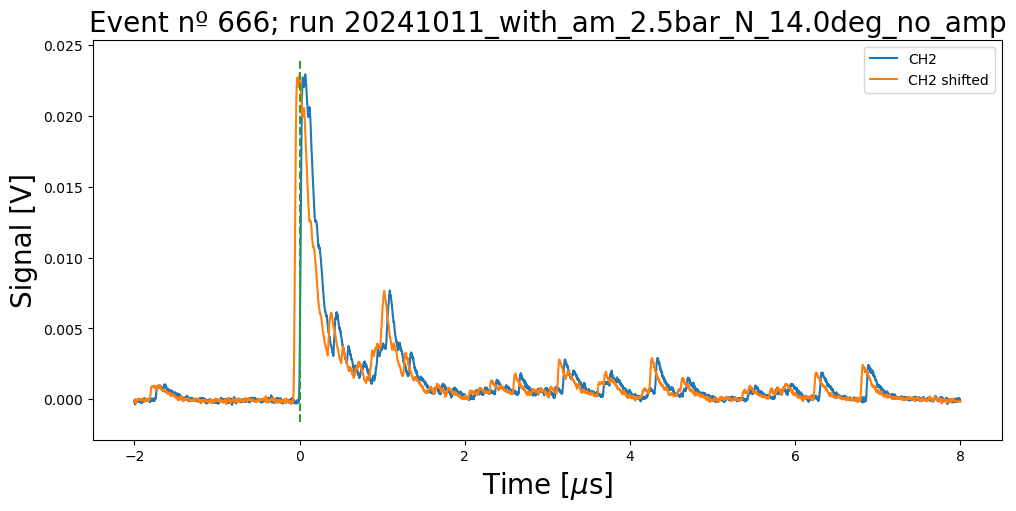

In [37]:
ax = print_wvf(event_df, channel = channel)

ax.plot(shifted_df.TIME*1e6, shifted_df[f'CH{channel}'], label = f'CH{channel} shifted')

# Get current y-axis limits
y_min, y_max = ax.get_ylim()
ax.plot(np.zeros(100), np.linspace(y_min, y_max, 100), '--')

ax.legend(loc = 'best')

In [40]:
ShiftedAndCorrected_df = ShiftWaveformToPeak(corrected_df)

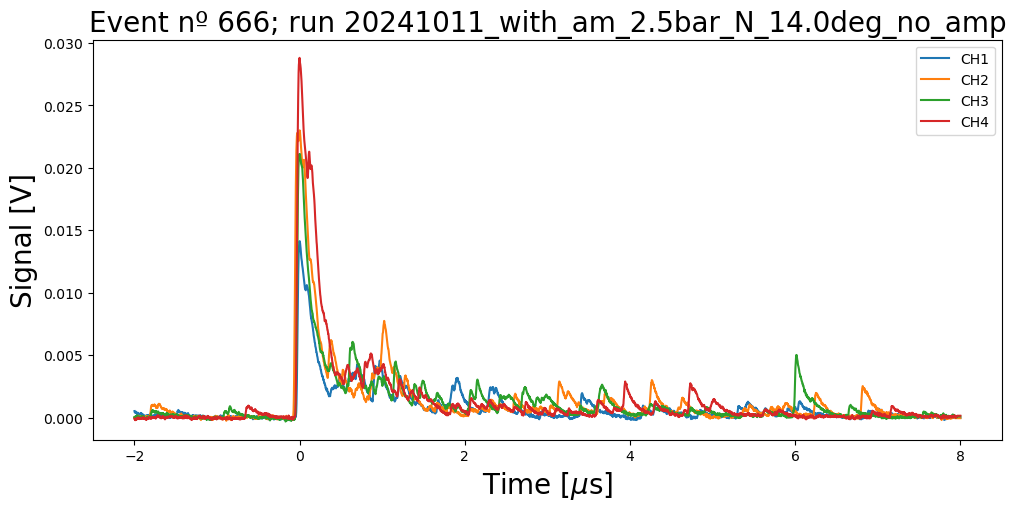

In [41]:
ax = print_wvf(ShiftedAndCorrected_df, channel = all)

ax.legend(loc = 'best')

# ax.set_xlim(0, 0.06)

###  Mean waveform

In [13]:
# Step 0: Correct baseline and shift peak
# corrected_df = run_df.groupby('event').apply(BaselineAndPeakCorrection).reset_index(drop=True)
# shifted_df = corrected_df.groupby('event').apply(ShiftWaveformToPeak).reset_index(drop=True)
shifted_df = run_df.groupby('event').apply(ShiftWaveformToPeak).reset_index(drop=True)
corrected_df = shifted_df.groupby('event').apply(BaselineAndPeakCorrection).reset_index(drop=True)

# Step 1: Group by 'event' and create a list of waveforms for each channel
# grouped = shifted_df.groupby('event').agg(list)
grouped = corrected_df.groupby('event').agg(list)

# Convert the lists to numpy arrays
grouped_arrays = grouped.applymap(np.array)

# Step 3: Calculate the mean without using lambda
mean_waveform = grouped_arrays.apply(np.mean, axis=0)
mean_waveform['event'] = 'mean'

mean_waveform = BaselineAndPeakCorrection(mean_waveform)

In [14]:
# corrected_df

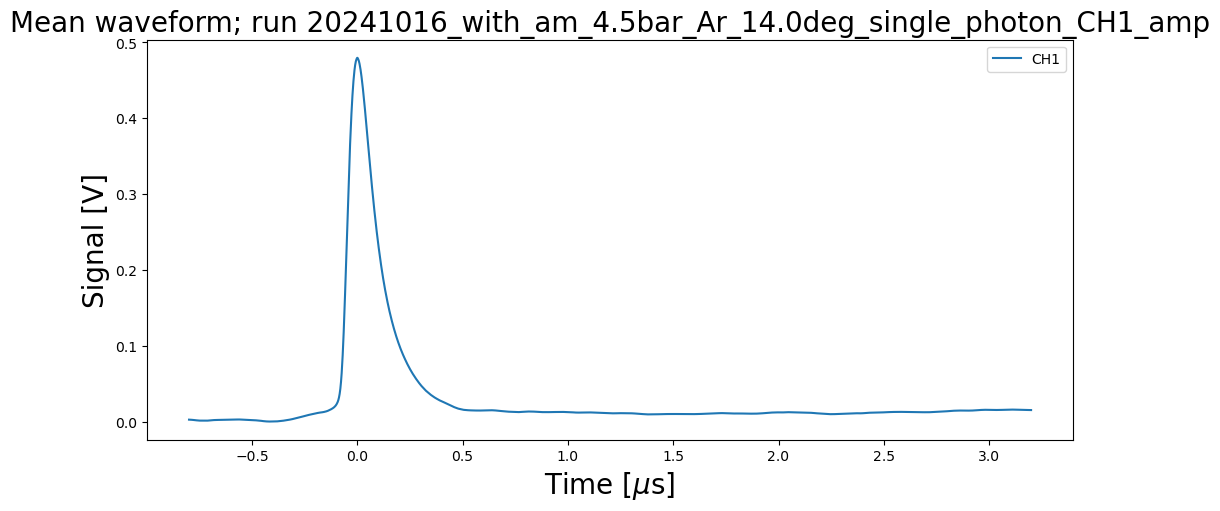

In [49]:
ax = print_wvf(mean_waveform, title = 'Mean waveform', channel = 1)

# ax.set_xlim(3.1, 3.21)

ax.legend(loc = 'best', ncol = 4)


#  $\tau$ calculation

###  Individual waveforms

In [33]:
event = 1162
event = 4


In [34]:
event_df = run_df.groupby('event').get_group(event)

In [35]:
shifted_df = event_df.groupby('event').apply(ShiftWaveformToPeak).reset_index(drop=True)
corrected_df = shifted_df.groupby('event').apply(BaselineAndPeakCorrection).reset_index(drop=True)

In [36]:
df = corrected_df


In [37]:
initial_guesses = {} # [t0, rise, tau, mu, sigma]
initial_guesses['CH1'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us] 
initial_guesses['CH2'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us]
initial_guesses['CH3'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us]
initial_guesses['CH4'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us]

In [38]:
channel = 2

In [39]:
t = df.TIME*1e6 # [us]

wvf = df[f'CH{channel}'] # [V]
baseline = wvf.min() # [V]
# baseline = wvf[wvf<0].mean() # [V]

t_window = t < np.inf # [us]
# t_window = t < t.mean() # [us]
# t_window = (t > -0.5) & (t < t.mean()) # [us]
# t_window = (t > -0.5) & (t < 0.5) # [us]
df_area = np.trapz(x = t[t_window], y = wvf[t_window])

# Sample data
waveform_time = t  # Your waveform_time data here
measured_data = wvf  # Your measured data to fit

# Initial guesses for the parameters
# initial_guess = [initial_time_guess, rise_time_guess, decay_time_guess, mu_guess, sigma_guess] all in [ns]
initial_guess = initial_guesses[f'CH{channel}']

# Perform the fit with bounds to keep parameters positive
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf])  # All parameters must be > 0

# Perform the fit
params, covariance = curve_fit(fit_function, waveform_time, measured_data, p0=initial_guess)

# Extract the optimized parameters
opt_t0, opt_rise, opt_tau, opt_mu, opt_sigma = params

/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [40]:
tau = opt_tau # [ns]
rise = opt_rise # [ns]
t0 = opt_t0
mu = opt_mu
sigma = opt_sigma

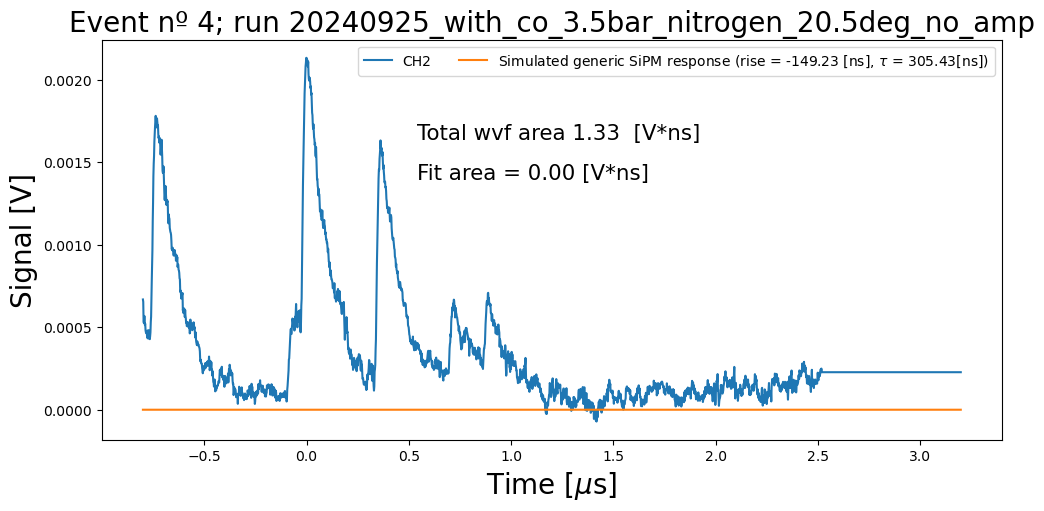

In [41]:
font_size = 22

ax = print_wvf(corrected_df, title = None, channel = channel)

generic_sipm_response = fit_function(t, t0, rise, tau, mu, sigma)
ax.plot(t, generic_sipm_response, 
        label = fr'Simulated generic SiPM response (rise = {rise*1e3:.2f} [ns], $\tau$ = {tau*1e3:.2f}[ns])')


sipm_area = np.trapz(x = t, y = wvf)
fit_area  = np.trapz(x = t, y = generic_sipm_response)
ax.text(0.35, .75, f'Total wvf area {sipm_area*1e3:.2f}  [V*ns]',
        transform=ax.transAxes, 
        fontsize=0.7*font_size, bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
ax.text(0.35, .65, f'Fit area = {fit_area*1e3:.2f} [V*ns]',
        transform=ax.transAxes, 
        fontsize=0.7*font_size, bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))


# ax.set_xlim(3.1, 3.21)

ax.legend(loc = 'best', ncol = 4)

In [53]:
initial_guesses = {} # [t0, rise, tau, mu, sigma]
initial_guesses['CH1'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us] 
initial_guesses['CH2'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us]
initial_guesses['CH3'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us]
initial_guesses['CH4'] = np.array([-50, 30, 120, 1200, 15])*1e-3  # [us]

decay_constants = {}
decay_constants['CH1'] = [] 
decay_constants['CH2'] = []
decay_constants['CH3'] = []
decay_constants['CH4'] = []


In [19]:
shifted_df = run_df.groupby('event').apply(ShiftWaveformToPeak).reset_index(drop=True)
corrected_df = shifted_df.groupby('event').apply(BaselineAndPeakCorrection).reset_index(drop=True)

In [46]:
wvf

10000    0.000087
10001    0.000063
10002    0.000094
10003    0.000079
10004    0.000080
           ...   
12495    0.000192
12496    0.000220
12497    0.000195
12498    0.000224
12499    0.000198
Name: CH2, Length: 2500, dtype: float64

In [27]:
for event in corrected_df.event.unique():
    
    df = run_df.groupby('event').get_group(event)
    t = np.array(df.TIME)*1e6 # [us]
    
    for channel in [1, 2, 3, 4]:
        
        print(f'event {event}, CH{channel}' + ' '*10, end = '\n')

        wvf = df[f'CH{channel}'] # [V]
        baseline = wvf.min() # [V]

        t_window = t < t.mean() # [us]
        df_area = np.trapz(x = t[t_window], y = wvf[t_window])

        # Sample data
        waveform_time = t  # Your waveform_time data here
        measured_data = wvf  # Your measured data to fit

        # Initial guesses for the parameters
        # initial_guess = [initial_time_guess, rise_time_guess, decay_time_guess, mu_guess, sigma_guess] all in [ns]
        initial_guess = initial_guesses[f'CH{channel}']

        # Perform the fit with bounds to keep parameters positive
        bounds = (0, np.inf)  # All parameters must be > 0

        # Perform the fit
        print('Finding the fit' + ' '*10, end = '')
        params, covariance = curve_fit(fit_function, waveform_time, measured_data, p0=initial_guess)
        print('DONE' + ' '*10, end = '')

        # Extract the optimized parameters
        opt_t0, opt_rise, opt_tau, opt_mu, opt_sigma = params
        
        decay_constants[f'CH{channel}'].append(opt_tau)

NameError: name 'corrected_df' is not defined

In [55]:
decay_constants

{'CH1': [0.06306106419254023], 'CH2': [], 'CH3': [], 'CH4': []}

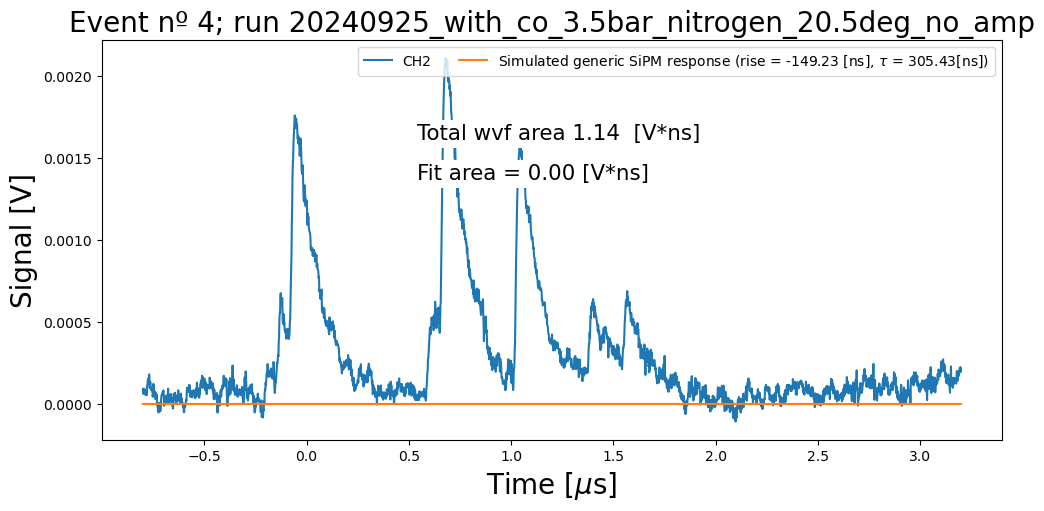

In [51]:
font_size = 22

ax = print_wvf(df, title = None, channel = channel)

generic_sipm_response = fit_function(t, t0, rise, tau, mu, sigma)
ax.plot(t, generic_sipm_response, 
        label = fr'Simulated generic SiPM response (rise = {rise*1e3:.2f} [ns], $\tau$ = {tau*1e3:.2f}[ns])')


sipm_area = np.trapz(x = t, y = wvf)
fit_area  = np.trapz(x = t, y = generic_sipm_response)
ax.text(0.35, .75, f'Total wvf area {sipm_area*1e3:.2f}  [V*ns]',
        transform=ax.transAxes, 
        fontsize=0.7*font_size, bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))
ax.text(0.35, .65, f'Fit area = {fit_area*1e3:.2f} [V*ns]',
        transform=ax.transAxes, 
        fontsize=0.7*font_size, bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))


# ax.set_xlim(3.1, 3.21)

ax.legend(loc = 'best', ncol = 4)

###  Mean waveform

In [ ]:
# Step 0: Correct baseline and shift peak
# corrected_df = run_df.groupby('event').apply(BaselineAndPeakCorrection).reset_index(drop=True)
# shifted_df = corrected_df.groupby('event').apply(ShiftWaveformToPeak).reset_index(drop=True)
shifted_df = run_df.groupby('event').apply(ShiftWaveformToPeak).reset_index(drop=True)
# corrected_df = shifted_df.groupby('event').apply(BaselineAndPeakCorrection).reset_index(drop=True)

# Step 1: Group by 'event' and create a list of waveforms for each channel
grouped = shifted_df.groupby('event').agg(list)
# grouped = corrected_df.groupby('event').agg(list)

# Convert the lists to numpy arrays
grouped_arrays = grouped.applymap(np.array)

# Step 3: Calculate the mean without using lambda
mean_waveform = grouped_arrays.apply(np.mean, axis=0)
mean_waveform['event'] = 'mean'

mean_waveform = BaselineAndPeakCorrection(mean_waveform)

In [ ]:
# corrected_df

In [16]:
channel = all

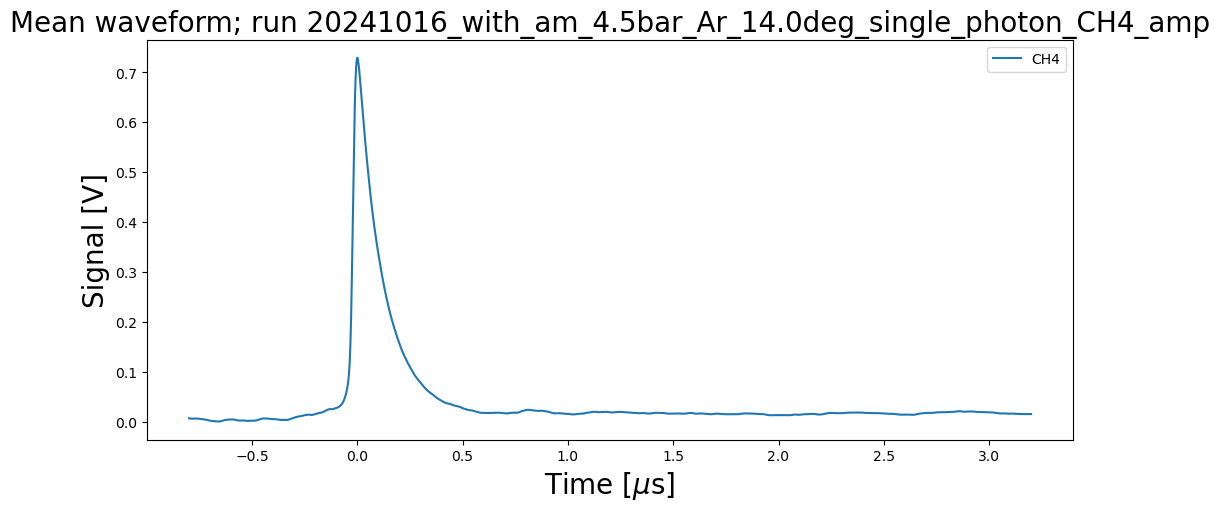

In [17]:
ax = print_wvf(mean_waveform, title = 'Mean waveform', channel = channel)

# ax.set_xlim(3.1, 3.21)

ax.legend(loc = 'best', ncol = 4)


In [18]:
initial_guesses = {} # [t0, rise, tau, mu, sigma]
initial_guesses['CH1'] = [-50, 30, 180, 1200, 2] # [ns] 
initial_guesses['CH2'] = [-80, 20, 180, 1200, 5] # [ns]
initial_guesses['CH3'] = [-50, 50, 150, 1200, 1] # [ns]
initial_guesses['CH4'] = [-50, 30, 150, 1200, 15] # [ns]

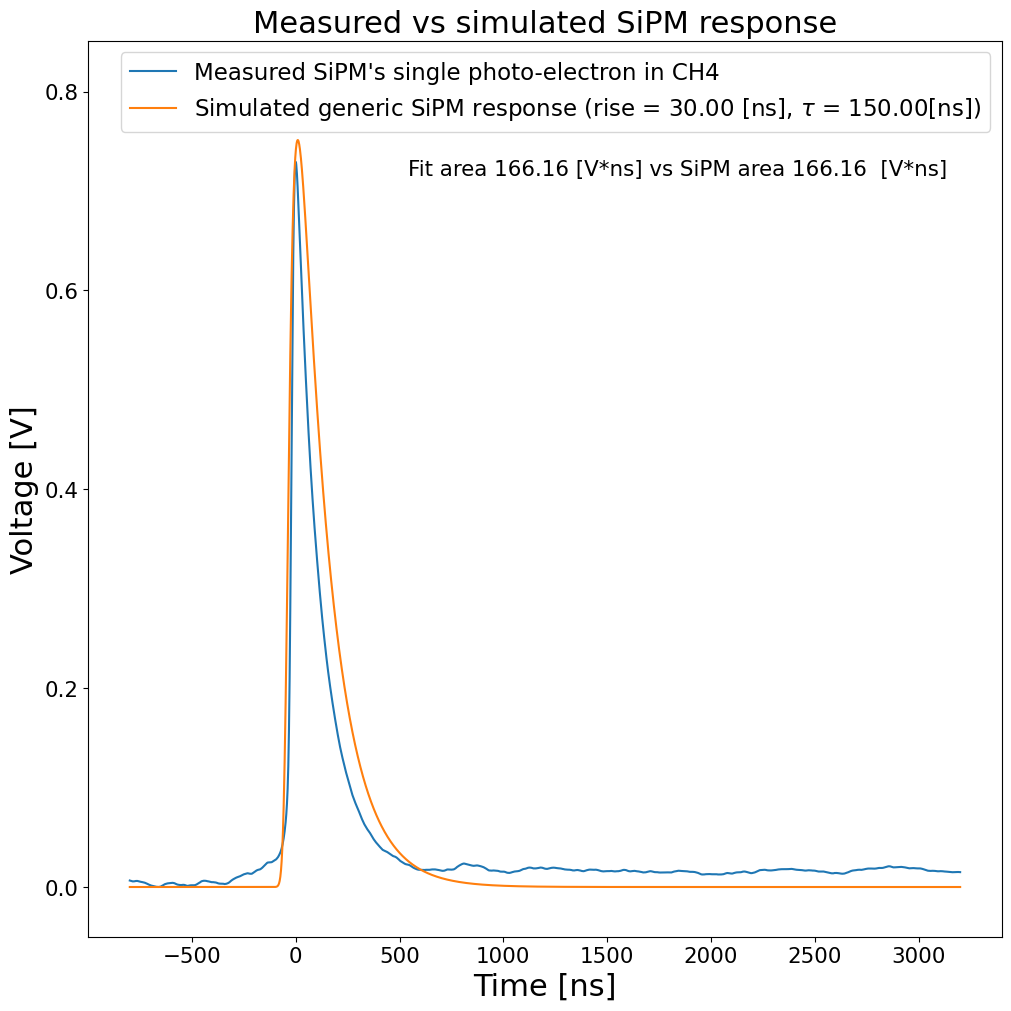

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 10), constrained_layout=True)

font_size = 22

df = mean_waveform
t = df.TIME*1e9 # [ns]
wvf = df[f'CH{channel}'] # [V]

df_area = np.trapz(x = t, y = wvf)
baseline = wvf.min() # [V]
wvf = wvf - baseline

# ax.plot(df.TIME, df.CH1)
ax.plot(t, wvf, alpha = 1, label = f'Measured SiPM\'s single photo-electron in CH{channel}') 

t0, rise, tau, mu, sigma = initial_guesses[f'CH{channel}']

generic_sipm_response = fit_function(t, t0, rise, tau, mu, sigma)
ax.plot(t, generic_sipm_response, 
        label = fr'Simulated generic SiPM response (rise = {rise:.2f} [ns], $\tau$ = {tau:.2f}[ns])')

sipm_area = df_area
fit_area  = np.trapz(x = t, y = generic_sipm_response)
ax.text(0.35, .85, f'Fit area {fit_area:.2f} [V*ns] vs SiPM area {sipm_area:.2f}  [V*ns]',
        transform=ax.transAxes, 
        fontsize=0.7*font_size, bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.legend(fontsize = 0.75*font_size)

margen = 0.1
ax.set_ylim(wvf.min() - 0.5*margen, max(wvf.max(), generic_sipm_response.max()) + margen)

ax.tick_params(axis='both', labelsize = font_size*0.7)

ax.set_title(f'Measured vs simulated SiPM response', fontsize = font_size);
ax.set_xlabel(f'Time [ns]', fontsize = font_size);
ax.set_ylabel('Voltage [V]', fontsize = font_size);

In [20]:
initial_guesses = {} # [t0, rise, tau, mu, sigma]
initial_guesses['CH1'] = [-50, 30, 180, 1200, 5]
initial_guesses['CH2'] = [-80, 100, 180, 1200, 5]
initial_guesses['CH3'] = [-50, 50, 180, 1200, 1]
initial_guesses['CH4'] = [-50, 30, 150, 1200, 15]


In [21]:
df = mean_waveform


In [22]:
t = df.TIME*1e9 # [ns]
wvf = df[f'CH{channel}'] # [V]
baseline = wvf.min() # [V]
df_area = np.trapz(x = t, y = wvf)

# Sample data
waveform_time = t  # Your waveform_time data here
measured_data = wvf  # Your measured data to fit

# Initial guesses for the parameters
# initial_guess = [initial_time_guess, rise_time_guess, decay_time_guess, mu_guess, sigma_guess] all in [ns]
initial_guess = initial_guesses[f'CH{channel}']

# Perform the fit with bounds to keep parameters positive
bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf])  # All parameters must be > 0

# Perform the fit
params, covariance = curve_fit(fit_function, waveform_time, measured_data, p0=initial_guess)

# Extract the optimized parameters
opt_t0, opt_rise, opt_tau, opt_mu, opt_sigma = params

/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
opt_t0, opt_rise, opt_tau, opt_mu, opt_sigma

(-40.39088998398927,
 0.0283718058638903,
 207.9206154033304,
 1211.8065877101835,
 13.040541158411807)

In [24]:
tau = opt_tau # [ns]
rise = opt_rise # [ns]
t0 = opt_t0
mu = opt_mu
sigma = opt_sigma

/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


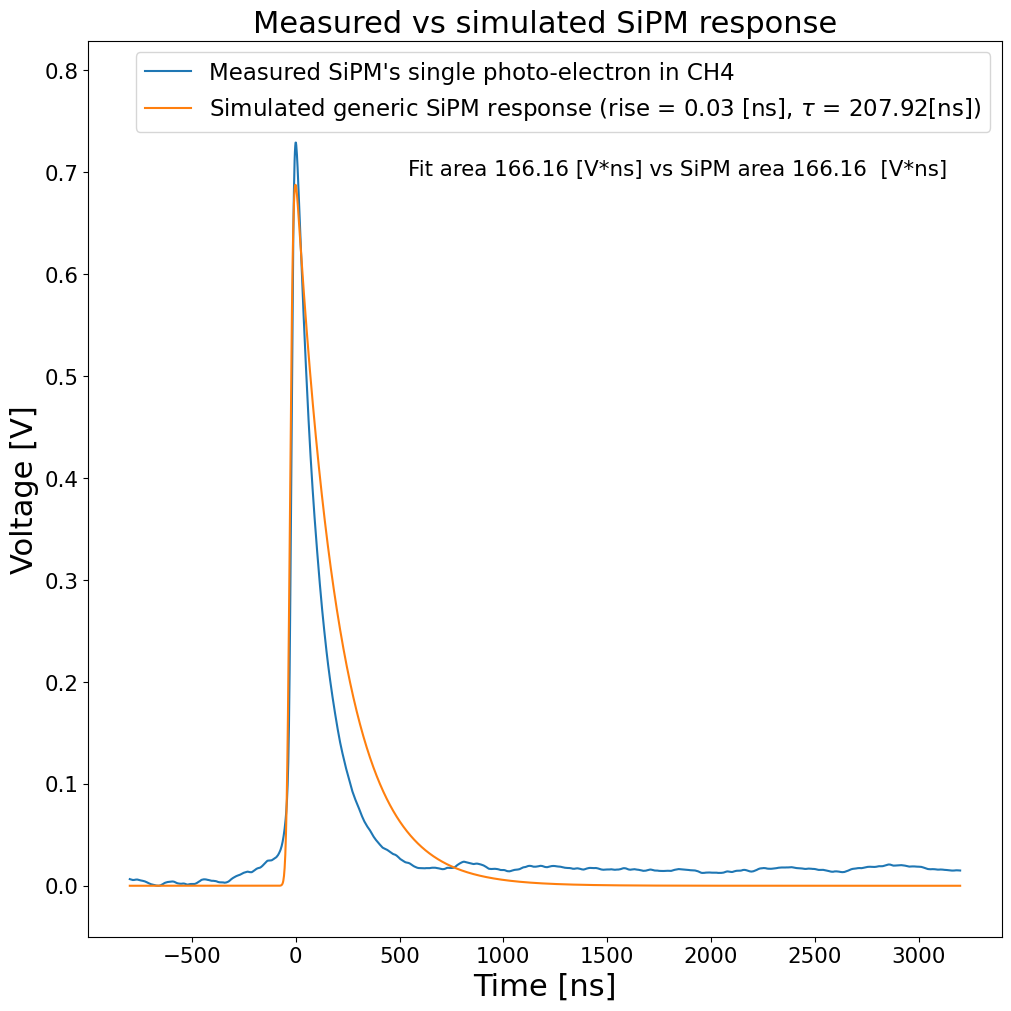

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 10), constrained_layout=True)

font_size = 22

t = df.TIME*1e9 # [ns]
wvf = df[f'CH{channel}'] # [V]

df_area = np.trapz(x = t, y = wvf)
baseline = wvf.min() # [V]
wvf = wvf - baseline

# ax.plot(df.TIME, df.CH1)
ax.plot(t, wvf, alpha = 1, label = f'Measured SiPM\'s single photo-electron in CH{channel}') 

generic_sipm_response = fit_function(t, t0, rise, tau, mu, sigma)
ax.plot(t, generic_sipm_response, 
        label = fr'Simulated generic SiPM response (rise = {rise:.2f} [ns], $\tau$ = {tau:.2f}[ns])')

sipm_area = df_area
fit_area  = np.trapz(x = t, y = generic_sipm_response)
ax.text(0.35, .85, f'Fit area {fit_area:.2f} [V*ns] vs SiPM area {sipm_area:.2f}  [V*ns]',
        transform=ax.transAxes, 
        fontsize=0.7*font_size, bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.legend(fontsize = 0.75*font_size)

margen = 0.1
ax.set_ylim(wvf.min() - 0.5*margen, max(wvf.max(), generic_sipm_response.max()) + margen)

ax.tick_params(axis='both', labelsize = font_size*0.7)

ax.set_title(f'Measured vs simulated SiPM response', fontsize = font_size);
ax.set_xlabel(f'Time [ns]', fontsize = font_size);
ax.set_ylabel('Voltage [V]', fontsize = font_size);

##  Multiphoton spectrum

In [14]:
# %%timeit

charge_df = pd.DataFrame([])

for selected_run in range(n_files):
# for selected_run in range(1):
    
    run_file = os.path.join(run_path, f"{run}_{selected_run}.h5")
    print(f'Processing... {run_file}' + ' '*20, end = '\r')
    
    run_df = pd.read_hdf(run_file)    
    
    # Group by 'event' and apply the integral calculation
    integrals = run_df.groupby('event').apply(calculate_integral).reset_index(drop=True)
    
    # Stack the DataFrames vertically using pd.concat
    charge_df = pd.concat([charge_df, integrals], axis=0).reset_index(drop=True)

In [15]:

A0     = {'CH1': [3.2, 2.2, 1.5, 0.9, 0.5, 0.25],
          'CH2': [3, 2, 1.5, 0.9, 0.5, 0.25],
          'CH3': [5, 3, 1.5, 1, 0.55, 0.5],
          'CH4': [3, 2, 1.5, 0.9, 0.6, 0.25]
         }
mu0    = {'CH1': [0.025, 0.057, 0.09, 0.125, 0.16, 0.2],
          'CH2': [0.03, 0.062, 0.1, 0.142, 0.18, 0.225],
          'CH3': [0.035, 0.08, 0.12, 0.17, 0.21, 0.26],
          'CH4': [0.03, 0.07, 0.112, 0.155, 0.2, 0.25]
         }
sigma0 = {'CH1': [0.008, 0.008, 0.012, 0.008, 0.008, 0.008],
          'CH2': [0.008, 0.008, 0.012, 0.012, 0.012, 0.012],
          'CH3': [0.01, 0.012, 0.012, 0.012, 0.012, 0.015],
          'CH4': [0.008, 0.012, 0.012, 0.012, 0.02, 0.012]
         }

In [16]:
channel = 4

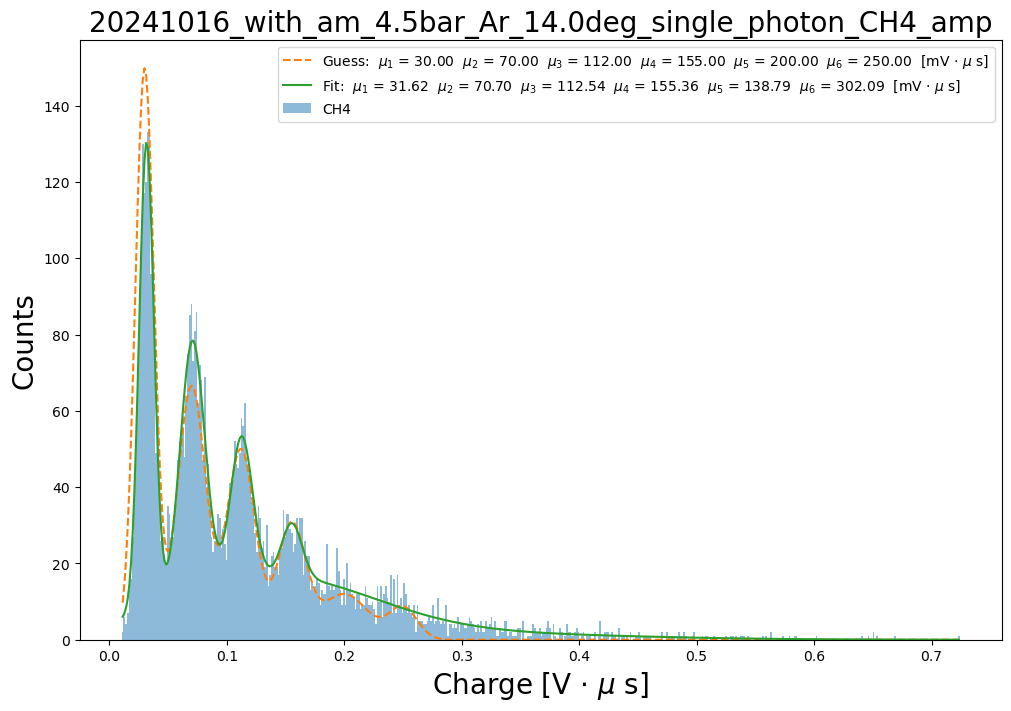

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7), constrained_layout=True)

font_size = 20
pes = False

# for i, ii in enumerate([1, 2, 3, 4]):
for i, ii in enumerate([channel]):
    
    if pes:
        charge_in_pes = ChargeToPes(charge_df[f'charge_CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])
        events, bins, image = ax.hist(charge_in_pes, bins = 400, label = f'CH{ii}', alpha = 0.5)
    else:
        events, bins, image = ax.hist(charge_df[f'charge_CH{ii}'], bins = 500, label = f'CH{ii}', alpha = 0.5)

# ax.set_title(f'Multiphoton spectrum', fontsize = font_size);
ax.set_title(f'{run}', fontsize = font_size);

if pes:
    ax.set_xlabel(r'Charge [pes]', fontsize = font_size);
else:
    ax.set_xlabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);


bins_means = (bins[:-1] + bins[1:])/2

x = bins_means
y = events

initial_guess_A     = A0[f'CH{channel}']
initial_guess_mu    = mu0[f'CH{channel}'] 
initial_guess_sigma = sigma0[f'CH{channel}']


# Initial guesses for the parameters
initial_guess = initial_guess_A + initial_guess_mu + initial_guess_sigma

gaussian_sum = sum_of_gaussians(x, *initial_guess)
gaussian_label = 'Guess: '
for i, mu in enumerate(initial_guess_mu):
    gaussian_label += fr" $\mu_{i+1}$ = {mu*1e3:.2f} "
gaussian_label += r' [mV $\cdot$ $\mu$ s]'

ax.plot(x, gaussian_sum, '--', label = gaussian_label)


# Perform the fit with bounds to keep parameters positive
bounds = (0, np.inf)  # All parameters must be > 0

# Perform the fit
params, covariance = curve_fit(sum_of_gaussians, x, y, p0=initial_guess)

# Extract the optimized parameters
# Extract optimized parameters (split them into A, mu, sigma)
num_gaussians = len(initial_guess_A)
opt_A = params[:num_gaussians]
opt_mu = params[num_gaussians:2*num_gaussians]
opt_sigma = params[2*num_gaussians:]
# Extract errors (standard deviations) for each mu
opt_mu_errors = np.sqrt(np.diag(covariance)[num_gaussians:2*num_gaussians])


gaussian_sum = sum_of_gaussians(x, *params)
gaussian_label = 'Fit: '
for i, mu in enumerate(opt_mu):
    gaussian_label += fr" $\mu_{i+1}$ = {mu*1e3:.2f} "
gaussian_label += r' [mV $\cdot$ $\mu$ s]'
ax.plot(x, gaussian_sum, label = gaussian_label)

ax.set_ylabel(r'Counts', fontsize = font_size);

# ax.set_yscale('log')
ax.legend(loc = 'best')

In [19]:
opt_mu, opt_mu_errors

(array([0.03161526, 0.07069741, 0.11253566, 0.15535887, 0.13878754,
        0.30208563]),
 array([8.89827776e-05, 2.24180162e-04, 3.61957158e-04, 9.26210713e-04,
        1.68989756e-02, 5.96012358e-01]))

In [14]:
pes_spectrum = {'CH1': [0.02578544, 0.05701846, 0.090643  , 0.12286971, 0.15575065],
                'CH2': [0.02853297, 0.06364668, 0.1021905 , 0.1418635 , 0.17868483],
                'CH3': [0.03441694, 0.07819412, 0.12275633, 0.16764172],
                'CH4': [0.03161526, 0.07069741, 0.11253566, 0.15535887]
               }
err_spectrum = {'CH1': [5.43955119e-05, 1.42976691e-04, 2.53215742e-04, 4.10540191e-04, 1.12895098e-03],
                'CH2': [7.00051885e-05, 1.92389625e-04, 4.23148907e-04, 8.69509565e-04, 9.21784812e-04],
                'CH3': [5.98757941e-05, 1.81381853e-04, 4.30881470e-04, 7.96605232e-04],
                'CH4': [8.89827776e-05, 2.24180162e-04, 3.61957158e-04, 9.26210713e-04]
               }

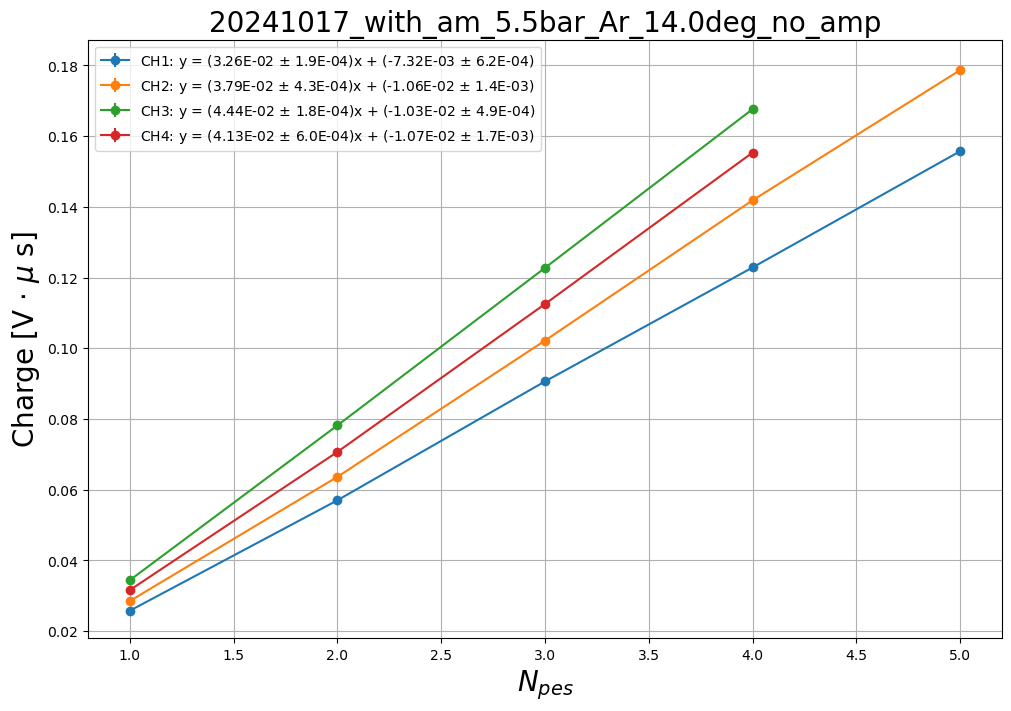

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7), constrained_layout=True)

font_size = 20


for ch in pes_spectrum.keys():
# for ch in ['CH3']:

    x = np.arange(len(pes_spectrum[ch])) + 1
    y = pes_spectrum[ch]

    # Perform linear fit and get covariance matrix
    params, cov = np.polyfit(x, y, 1, cov=True)
    slope, intercept = params

    # Get errors (standard deviations) from the covariance matrix
    slope_err = np.sqrt(cov[0, 0])
    intercept_err = np.sqrt(cov[1, 1])
    
    ax.errorbar(x, y, yerr = err_spectrum[ch],  fmt = 'o-', 
                label = fr'{ch}: y = ({slope:.2E} $\pm$ {slope_err:.1E})x + ({intercept:.2E} $\pm$ {intercept_err:.1E})')
    
#     ax.plot(x, slope*x + intercept, '--', label = f'{ch} fit')


ax.set_title(f'{run}', fontsize = font_size);
ax.set_xlabel(r'$N_{pes}$', fontsize = font_size);
ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);
ax.grid(True)

ax.legend()

##  Signal peak

In [12]:
# run      = '20241011_with_am_3.5bar_N_14.0deg_no_amp' # 50 files
# run      = '20241016_with_am_4.5bar_N_14.0deg_no_amp' # 50 files
run      = '20241011_with_am_2.5bar_N_14.0deg_no_amp' # 34 files

run_path = os.path.join(path, run) 

# Use glob to find all .h5 files in the directory
h5_files = glob.glob(f"{run_path}/*.h5")
h5_files = sorted(h5_files, key=extract_number_h5)


# n_files = 34


In [18]:
ch1s = []
ch1s_err = []
ch2s = []
ch2s_err = []
ch3s = []
ch3s_err = []
ch4s = []
ch4s_err = []

time_ticks = 6250


for file in h5_files[:3]:
    
    print(f'Processing... {file}' + ' '*20, end = '\r')
    
    df = pd.read_hdf(file)
    
    time = df["TIME"].to_numpy()[:time_ticks]
    ch1 = df["CH1"].to_numpy().reshape(-1, time_ticks)
    ch2 = df["CH2"].to_numpy().reshape(-1, time_ticks)
    ch3 = df["CH3"].to_numpy().reshape(-1, time_ticks)
    ch4 = df["CH4"].to_numpy().reshape(-1, time_ticks)
    
    integration_window = (time > -0.3e-6) & (time < 0.7e-6)
    
    ch1_area = np.trapz(ch1[:, integration_window], time[integration_window], axis=1)
    ch2_area = np.trapz(ch2[:, integration_window], time[integration_window], axis=1)
    ch3_area = np.trapz(ch3[:, integration_window], time[integration_window], axis=1)
    ch4_area = np.trapz(ch4[:, integration_window], time[integration_window], axis=1)
    
    ch1s.append(ch1_area)
    ch2s.append(ch2_area)
    ch3s.append(ch3_area)
    ch4s.append(ch4_area)
    
#     ch1s_err.append(np.std(ch1_area))
#     ch2s_err.append(np.std(ch2_area))
#     ch3s_err.append(np.std(ch3_area))
#     ch4s_err.append(np.std(ch4_area))


In [22]:
df["CH1"].to_numpy().reshape(-1, time_ticks)

array([[-1.656250e-04, -2.578125e-04, -1.031250e-04, ...,  7.968750e-05,
         1.171875e-04,  1.875000e-05],
       [ 1.562500e-05, -6.250000e-06,  9.375000e-06, ...,  3.125000e-05,
         1.437500e-04,  9.843750e-05],
       [ 1.046875e-04,  1.312500e-04,  1.609375e-04, ...,  4.531250e-05,
         8.437500e-05,  2.109375e-04],
       ...,
       [ 2.656250e-05, -8.125000e-05, -3.125000e-05, ..., -1.718750e-04,
        -4.843750e-05, -1.875000e-05],
       [ 2.187500e-05, -5.156250e-05, -1.140625e-04, ..., -7.187500e-05,
        -1.515625e-04, -4.687500e-05],
       [-4.687500e-05, -1.343750e-04, -7.656250e-05, ...,  6.406250e-05,
         3.906250e-05,  1.171875e-04]])

In [17]:
ch1

array([[-1.437500e-04, -2.031250e-05, -2.031250e-05, ...,  8.281250e-05,
         2.062500e-04,  1.265625e-04],
       [ 1.078125e-04,  2.171875e-04,  2.171875e-04, ...,  1.575000e-03,
         1.665625e-03,  1.678125e-03],
       [-1.250000e-05, -4.218750e-05, -1.000000e-04, ..., -1.562500e-04,
        -2.093750e-04, -1.984375e-04],
       ...,
       [ 7.937500e-04,  7.875000e-04,  8.421875e-04, ..., -3.125000e-05,
        -8.281250e-05,  9.218750e-05],
       [ 9.687500e-05,  6.718750e-05, -6.250000e-06, ...,  9.687500e-05,
         2.593750e-04,  9.531250e-05],
       [ 4.687500e-05,  3.125000e-06,  8.125000e-05, ...,  3.906250e-05,
        -7.187500e-05, -6.250000e-05]])

In [38]:
charge_df.charge_CH2[charge_df.charge_CH1 < 0]

56     -0.031332
61      0.002446
105     0.000569
119     0.004247
138     0.003471
          ...   
3926    0.002549
3929    0.001217
3934    0.002104
3953   -0.013222
3996   -0.000085
Name: charge_CH2, Length: 197, dtype: float64

In [21]:
integrals.loc[integrals.charge_CH1 < 0]

,charge_CH1,charge_CH2,charge_CH3,charge_CH4
105,-0.000642,-0.000592,0.004024,0.000641
119,-0.001029,0.005224,0.003986,0.003496
163,-0.001062,0.001156,0.002865,-0.003889
192,-0.000013,-0.005342,0.014463,-0.000296
199,-0.000261,0.001172,0.001051,0.001640
...,...,...,...,...
1867,-0.004053,0.016371,0.010773,0.007469
1920,-0.000702,0.014650,0.009593,0.008518
1934,-0.002721,0.001649,0.001962,0.000070
1941,-0.001254,-0.000035,0.000316,-0.000767


In [13]:
# %%timeit

charge_df = pd.DataFrame([])

# Loop over only the first 3 .h5 files
for run_file in h5_files[:2]:  # Slice the list to get only the first 3
    try:
        # Reading the .h5 file using pandas
        run_df = pd.read_hdf(run_file)    
    
    #     run_file = os.path.join(run_path, f"{run}_{selected_run}.h5")
        print(f'Processing... {run_file}' + ' '*20, end = '\r')

        # You can now process `df` here
        
        # Group by 'event' and apply the integral calculation
        integrals = run_df.groupby('event').apply(calculate_integral).reset_index(drop=True)
        
        # Stack the DataFrames vertically using pd.concat
        charge_df = pd.concat([charge_df, integrals], axis=0).reset_index(drop=True)
        
    except Exception as e:
        print(f"Error reading {file}: {e}")

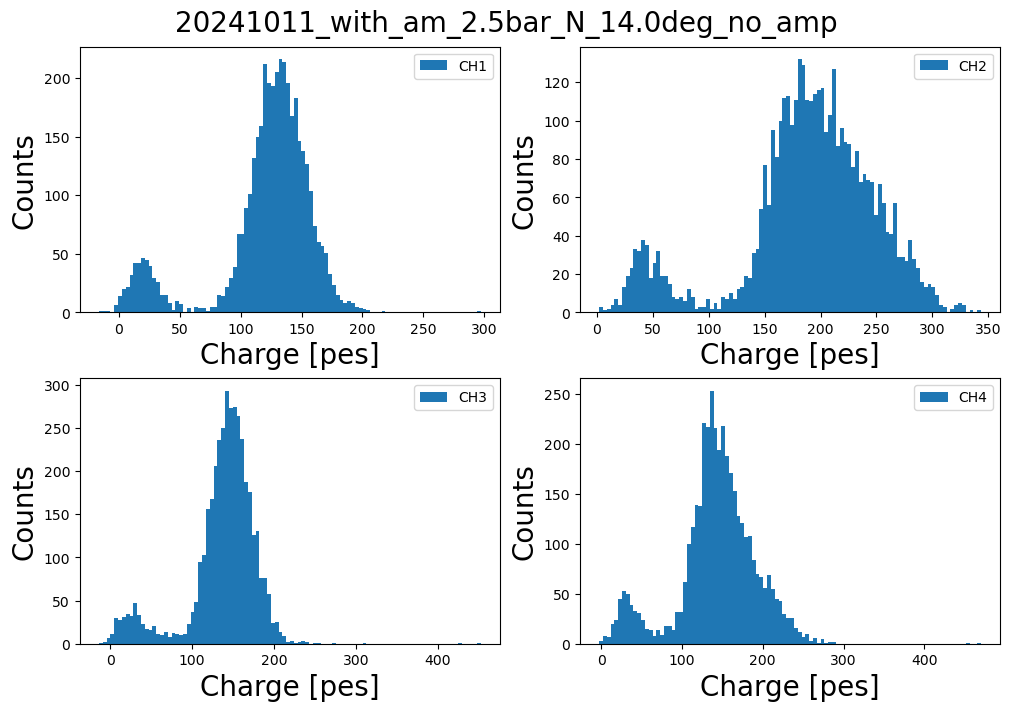

In [14]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,7), constrained_layout=True)

font_size = 20

pes = True

for i, ii in enumerate([1, 2, 3, 4]):
# for i, ii in enumerate([4]):
    axx = ax[(i // 2) % 2, i%2]

    if pes:
        charge_in_pes = ChargeToPes(charge_df[f'charge_CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])
        events, bins, image = axx.hist(charge_in_pes, bins = 100, label = f'CH{ii}', alpha = 1)
    else:
        events, bins, image = axx.hist(charge_df[f'charge_CH{ii}'], bins = 100, label = f'CH{ii}', alpha = 1)

    # axx.set_title(f'Multiphoton spectrum', fontsize = font_size);
#     axx.set_title(f'{run}', fontsize = font_size);

    if pes:
        axx.set_xlabel(r'Charge [pes]', fontsize = font_size);
    else:
        axx.set_xlabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);
        
    axx.set_ylabel(r'Counts', fontsize = font_size);

    # axx.set_yscale('log')
    axx.legend(loc = 'best')
    
# Set a general title for the entire figure
fig.suptitle(f'{run}', fontsize = font_size);

In [15]:
# ChargeToPes(charge_df['charge_CH1']*CHAmp['CH1'], *ConvPar['CH1'])

In [16]:
# charge_df, charge_df.sum(axis = 1)

In [17]:
# charge_in_pes

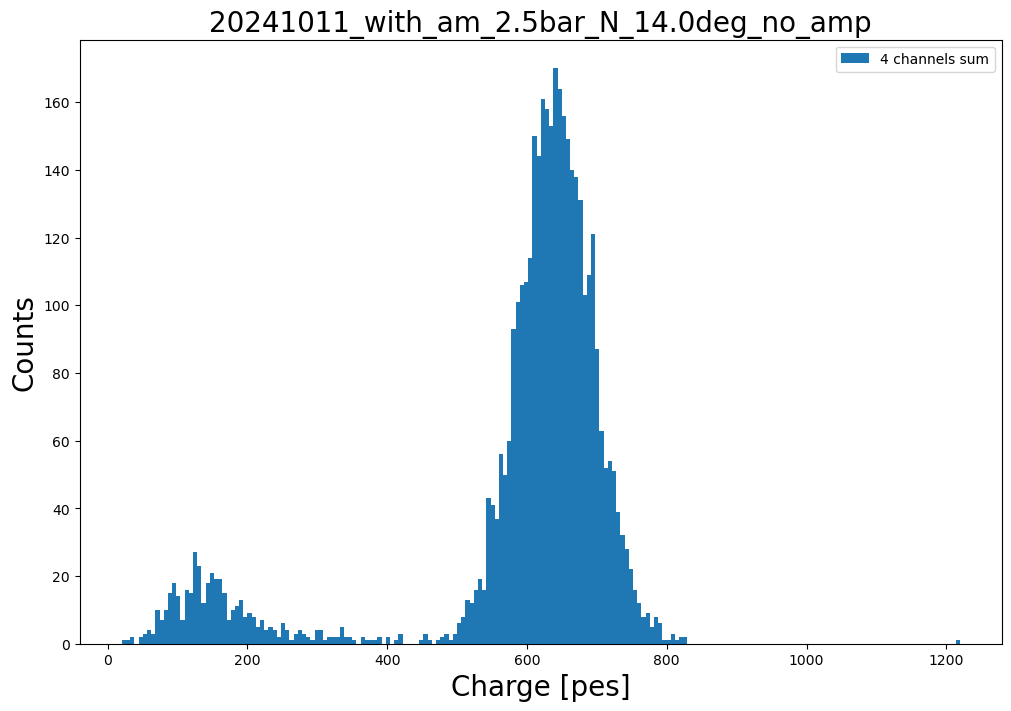

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7), constrained_layout=True)

font_size = 20

charge_in_pes = pd.DataFrame([])

for i, ii in enumerate([1, 2, 3, 4]):
# for i, ii in enumerate([4]):

    charge_in_pes[f'charge_CH{ii}'] = ChargeToPes(charge_df[f'charge_CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

total_charge_in_pes = charge_in_pes.sum(axis = 1)
    
events, bins, image = ax.hist(total_charge_in_pes, bins = 200, label = f'4 channels sum', alpha = 1 - .2*0)

# ax.set_title(f'Multiphoton spectrum', fontsize = font_size);
ax.set_title(f'{run}', fontsize = font_size);
ax.set_xlabel(r'Charge [pes]', fontsize = font_size);
ax.set_ylabel(r'Counts', fontsize = font_size);

# ax.set_yscale('log')
ax.legend(loc = 'best')
# ax.set_xlim(0, 1300)

#  Time profile

In [11]:
# run      = '20240925_with_co_3.5bar_nitrogen_20.5deg_no_amp' # 33 files
# run      = '20241011_with_am_2.5bar_N_14.0deg_no_amp' # 34 files
# run      = '20241017_with_am_5.5bar_Ar_14.0deg_no_amp' # 38 files
run      = '20241016_with_am_4.5bar_Ar_peltierOFF_no_amp' # 50 files

run_path = os.path.join(path, run) 

n_files = 50


In [12]:
# RUN IN TERMINAL TO GET TIMETABLE
import subprocess

def print_timetable(folder):

    # Step 1: Execute the command for .h5 files
    result = subprocess.run('ls *.h5 -lthr', capture_output=True, text=True, shell=True)

    # Step 2: Split the output into lines
    lines = result.stdout.splitlines()

    # Step 3: Extract time information
    time_info = []
    for line in lines[1:]:  # Skip the first line (header)
        parts = line.split()
        if len(parts) >= 7:  # Ensure there are enough parts
            # Extract the month, day, and time (or year)
            month = parts[5]
            day = parts[6]
            time_or_year = parts[7]  # This will be time or year depending on the date
            time_info.append(f"{month} {day} {time_or_year}")

    # Print the result
    print(time_info)

[]


In [13]:
timetable = ['oct 16 18:12', 'oct 16 18:30', 'oct 16 18:48', 'oct 16 19:05', 'oct 16 19:23', 
             'oct 16 19:40', 'oct 16 19:58', 'oct 16 20:16', 'oct 16 20:33', 'oct 16 20:51', 
             'oct 16 21:09', 'oct 16 21:26', 'oct 16 21:44', 'oct 16 22:02', 'oct 16 22:19', 
             'oct 16 22:37', 'oct 16 22:55', 'oct 16 23:12', 'oct 16 23:30', 'oct 16 23:48', 
             'oct 17 00:05', 'oct 17 00:23', 'oct 17 00:41', 'oct 17 00:59', 'oct 17 01:16', 
             'oct 17 01:34', 'oct 17 01:52', 'oct 17 02:09', 'oct 17 02:27', 'oct 17 02:45', 
             'oct 17 03:02', 'oct 17 03:20', 'oct 17 03:38', 'oct 17 03:55', 'oct 17 04:13', 
             'oct 17 04:30', 'oct 17 04:48', 'oct 17 05:05', 'oct 17 05:23', 'oct 17 05:41', 
             'oct 17 05:58', 'oct 17 06:16', 'oct 17 06:34', 'oct 17 06:51', 'oct 17 07:09', 
             'oct 17 07:27', 'oct 17 07:44', 'oct 17 08:02', 'oct 17 08:19', 'oct 17 08:37']



# Get the current year (or set it to a specific year)
current_year = datetime.now().year

# Convert to datetime objects with the current year
creation_time = [datetime.strptime(f'{current_year} {time}', '%Y %b %d %H:%M') for time in timetable]

##  Mean charge per file VS File

In [16]:
# Create an empty DataFrame to store the results
charge_df = pd.DataFrame()

# Loop through the DataFrames and calculate means
# for selected_run in range(n_files):
for selected_run in range(2):
    
    run_file = os.path.join(run_path, f"{run}_{selected_run}.h5")
    print(f'Processing... {run_file}' + ' '*20, end = '\r')
    
    run_df = pd.read_hdf(run_file)    
    
    # Group by 'event' and apply the integral calculation
    integrals = run_df.groupby('event').apply(calculate_integral).reset_index(drop=True)
    
    # Calculate mean and std for each charge column while ignoring NaN values
    mean_values = integrals.mean(skipna=True).to_frame().T
    std_values = integrals.std(skipna=True).to_frame().T
    
    # Rename the columns without a loop using str.replace
    mean_values.columns = mean_values.columns.str.replace('charge', 'mean')
    std_values.columns = std_values.columns.str.replace('charge', 'std')
    
    run_charge_df = pd.concat([mean_values, std_values], axis=1)
    
    # Add the file number to the mean values
    run_charge_df['Run'] = selected_run
    run_charge_df['Nentries'] = len(integrals)
    
#     # Get the modification time
#     mod_time_epoch = os.path.getmtime(run_file)
#     # Convert to a readable format
#     mod_time_readable = datetime.fromtimestamp(mod_time_epoch).isoformat()
#     run_charge_df['RunTime'] = mod_time_readable
    # Get the modification time
    run_charge_df['RunTime'] = creation_time[selected_run]
    
    # Append the result to the charge_df DataFrame
    charge_df = pd.concat([charge_df, run_charge_df], axis=0)
    

charge_df.RunTime = pd.to_datetime(charge_df.RunTime)
# Sort the DataFrame based on the 'x' column
sorted_df = charge_df.sort_values(by='RunTime')

In [18]:
charge_df

,mean_CH1,std_CH1,Run,Nentries,RunTime
0,0.002468,0.000511,0,2000,2024-10-16 18:12:00
0,0.002459,0.000533,1,2000,2024-10-16 18:30:00


No handles with labels found to put in legend.


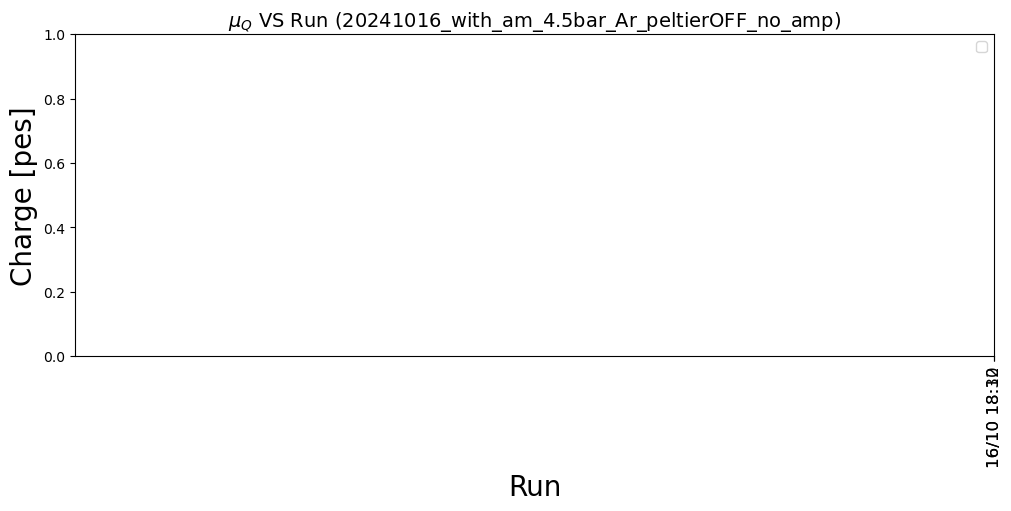

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

pes = True

run_id   = charge_df.Run
Nentries = charge_df.Nentries
run_time = pd.to_datetime(charge_df['RunTime']) 

# for i in [1, 2, 3, 4]:
# for i in [3]:

# Loop over all columns in the dataframe that start with 'CH'
for ii in charge_df.columns:
    if ii.startswith('CH'):
        i = ii[-1] 
        
        mean = charge_df[f'mean_CH{i}'] # [V*us]
        std = charge_df[f'std_CH{i}'] # [V*us]

        if pes:
            mean = ChargeToPes(mean*CHAmp[f'CH{i}'], *ConvPar[f'CH{i}'])
            std = ChargeToPes(std*CHAmp[f'CH{i}'], *ConvPar[f'CH{i}'])

        mean_error = std/np.sqrt(Nentries)

    #     ax.errorbar(run_id, mean, yerr = mean_error, fmt = 'o-', label = f'CH{i}')
        ax.errorbar(run_time, mean, yerr = mean_error, fmt = 'o-', label = f'CH{i}')


# Set x-ticks without rotation first
ax.set_xticks(run_time)
# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)
# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)
    
ax.set_title(fr'$\mu_Q$ VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);

if pes:
    ax.set_ylabel(r'Charge [pes]', fontsize = font_size);
else:
    ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(0.9e-3, 2.2e-3)

ax.legend(ncol = 4)

##  Median charge per file VS File

In [ ]:
# Create an empty DataFrame to store the results
charge_df = pd.DataFrame()

# Loop through the DataFrames and calculate means
for selected_run in range(n_files):
# for selected_run in range(2):
    
    run_file = os.path.join(run_path, f"{run}_{selected_run}.h5")
    print(f'Processing... {run_file}' + ' '*20, end = '\r')
    
    run_df = pd.read_hdf(run_file)    
    
    # Group by 'event' and apply the integral calculation
    integrals = run_df.groupby('event').apply(calculate_integral).reset_index(drop=True)
    
    # Calculate median and percentiles and std for each charge column while ignoring NaN values
    median_values = integrals.copy().median(skipna=True).to_frame().T.reset_index(drop=True)
    percentile_70_values = integrals.copy().quantile(0.70).to_frame().T.reset_index(drop=True)
    percentile_90_values = integrals.copy().quantile(0.90).to_frame().T.reset_index(drop=True)
    
    std_values = integrals.copy().std(skipna=True).to_frame().T.reset_index(drop=True)
    
    # Rename the columns without a loop using str.replace
    median_values.columns = median_values.columns.str.replace('charge', 'median')
    percentile_70_values.columns = percentile_70_values.columns.str.replace('charge', 'percentile_70')
    percentile_90_values.columns = percentile_90_values.columns.str.replace('charge', 'percentile_90')
    std_values.columns = std_values.columns.str.replace('charge', 'std')
    
    run_charge_df = pd.concat([median_values, 
                               percentile_70_values, 
                               percentile_90_values, 
                               std_values], axis=1)
    
    # Add the file number to the mean values
    run_charge_df['Run'] = selected_run
    run_charge_df['Nentries'] = len(integrals)
    
    # Get the modification time
    run_charge_df['RunTime'] = creation_time[selected_run]
    
    # Append the result to the charge_df DataFrame
    charge_df = pd.concat([charge_df, run_charge_df], axis=0)
    
charge_df.RunTime = pd.to_datetime(charge_df.RunTime)
# Sort the DataFrame based on the 'x' column
sorted_df = charge_df.sort_values(by='RunTime')

In [ ]:
run_time = pd.to_datetime(charge_df['RunTime']) 

In [ ]:
# for time in run_time:
#     print(time)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20
pes = True

run_id   = charge_df.Run
run_time = pd.to_datetime(charge_df.RunTime)
# run_time = charge_df.RunTime
Nentries = charge_df.Nentries

for i in [1, 2, 3, 4]:
# for i in [3]:

    median = charge_df[f'median_CH{i}'] # [V*us]
    std = charge_df[f'std_CH{i}'] # [V*us]
    
    if pes:
        median = ChargeToPes(median*CHAmp[f'CH{i}'], *ConvPar[f'CH{i}'])
        std = ChargeToPes(std*CHAmp[f'CH{i}'], *ConvPar[f'CH{i}'])
    
    median_error = 1.2533*std/np.sqrt(Nentries)
    
#     ax.errorbar(run_id, median, yerr = median_error, fmt = 'o-', label = f'CH{i}')
    ax.errorbar(run_time, median, yerr = median_error, fmt = 'o-', label = f'CH{i}')
    
# Set x-ticks without rotation first
ax.set_xticks(run_time)
# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)
# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)

# for label in current_xticklabels:
#     label.set_rotation(90)  # Rotate labels by 45 degrees
#     label.set_ha('center')
#     label.set_fontsize(12)  # Change the font size

ax.set_title(fr'median VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);

if pes:
    ax.set_ylabel(r'Charge [pes]', fontsize = font_size);
else:
    ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(0.9e-3, 2.2e-3)
# ax.set_ylim(5e-3, 8e-3)

ax.legend(ncol = 4)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

run_id   = charge_df.Run
run_time = pd.to_datetime(charge_df.RunTime)
# run_time = charge_df.RunTime
Nentries = charge_df.Nentries

for i in [1, 2, 3, 4]:
# for i in [3]:

    percentile_70 = charge_df[f'percentile_70_CH{i}'] # [V*us]
    std = charge_df[f'std_CH{i}'] # [V*us]
    
    percentile_70_error = 0.524*std/np.sqrt(Nentries)
    
#     ax.errorbar(run_id, percentile_70, yerr = percentile_70_error, fmt = 'o-', label = f'CH{i}')
    ax.errorbar(run_time, percentile_70, yerr = percentile_70_error, fmt = 'o-', label = f'CH{i}')
    
# Set x-ticks without rotation first
ax.set_xticks(run_time)
# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)
# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)

# for label in current_xticklabels:
#     label.set_rotation(90)  # Rotate labels by 45 degrees
#     label.set_ha('center')
#     label.set_fontsize(12)  # Change the font size

ax.set_title(fr'70% VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);
ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(5e-3, 8e-3)

ax.legend(ncol = 4)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

run_id   = charge_df.Run
run_time = pd.to_datetime(charge_df.RunTime)
# run_time = charge_df.RunTime
Nentries = charge_df.Nentries

for i in [1, 2, 3, 4]:
# for i in [3]:

    percentile_90 = charge_df[f'percentile_90_CH{i}'] # [V*us]
    std = charge_df[f'std_CH{i}'] # [V*us]
    
    percentile_90_error = 1.282*std/np.sqrt(Nentries)
    
#     ax.errorbar(run_id, percentile_90, yerr = percentile_90_error, fmt = 'o-', label = f'CH{i}')
    ax.errorbar(run_time, percentile_90, yerr = percentile_90_error, fmt = 'o-', label = f'CH{i}')
    
    
# Set x-ticks without rotation first
ax.set_xticks(run_time)

# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M')
ax.xaxis.set_major_formatter(date_format)

# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)


ax.set_title(fr'90% VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);
ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(0.9e-3, 2.2e-3)
# ax.set_ylim(5e-3, 8e-3)

ax.legend(ncol = 4)

#  Amplification study


In [1]:
# S2 signal script
import sys
sys.path.append('/home/investigator/mariandbt/python/notebooks/modules')

from datetime import datetime
import matplotlib.dates as mdates  # Import for date formatting

from import_modules import *
import set_up as setup
import s2_simulation as s2sim

from scipy.optimize import curve_fit

In [19]:
CH1 = np.array([0.548, 1.1, 1.65, 2.2, 2.75, 3.14, 3.14, 3.01, 3.05, 3.11, 3.11, 3.14, 3.14])
CH2 = np.array([0.550, 1.1, 1.65, 2.21, 2.76, 3.14, 3.15, 3.02, 3.06, 3.12, 3.12, 3.15, 3.15])

pulse12 = np.array([1.03, 2.03, 3.08, 4.08, 5.12, 6.14, 7.1, 5.64, 5.73, 5.93, 5.94, 7.99, 11.15])
pulse34 = np.array([1.03, 2.03, 3.08, 4.08, 5.12, 6.14, 7.1, 7.99, 8.56, 8.85, 9.03, 9.41, 9.6, 10.27, 10.05, 11.15])

CH3 = np.array([0.699, 1.39, 2.1, 2.79, 3.5, 4.19, 4.88, 5.45, 5.64, 5.75, 5.82, 5.93, 5.95, 5.96, 5.96, 5.95])
CH4 = np.array([0.687, 1.37, 2.06, 2.75, 3.43, 4.12, 4.81, 5.38, 5.62, 5.75, 5.83, 5.97, 6.03, 6.1, 6.1, 6.09])


In [20]:
len(CH3), len(pulse34)

(16, 16)

In [21]:
sorted_indices12

array([ 0,  1,  2,  3,  4,  7,  8,  9, 10,  5,  6, 11, 12])

(3.5, 6.5)

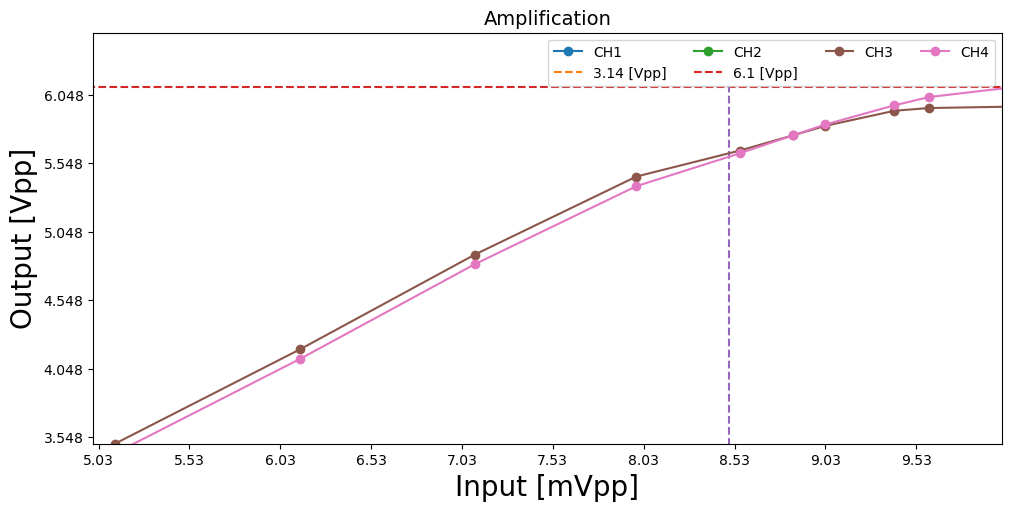

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

# Get the indices that would sort array2
sorted_indices12 = np.argsort(pulse12)
sorted_indices34 = np.argsort(pulse34)

# Use these indices to sort array1
sorted_pulse12 = pulse12[sorted_indices12]
sorted_pulse34 = pulse34[sorted_indices34]

sorted_CH1 = CH1[sorted_indices12]
sorted_CH2 = CH2[sorted_indices12]
sorted_CH3 = CH3[sorted_indices34]
sorted_CH4 = CH4[sorted_indices34]

ax.plot(sorted_pulse12, sorted_CH1, '-o', label = 'CH1')
ax.plot(sorted_pulse12, np.ones_like(sorted_pulse12)*3.14, '--', label = '3.14 [Vpp]')

ax.plot(sorted_pulse12, sorted_CH2, '-o', label = 'CH2')
ax.plot(sorted_pulse12, np.ones_like(sorted_pulse12)*6.1, '--', label = '6.1 [Vpp]')

ax.plot(np.ones_like(sorted_pulse34)*8.5, sorted_CH4, '--')

ax.plot(sorted_pulse34, sorted_CH3, '-o', label = 'CH3')
ax.plot(sorted_pulse34, sorted_CH4, '-o', label = 'CH4')


ax.set_title(fr'Amplification', fontsize = 0.7*font_size);
ax.set_xlabel('Input [mVpp]', fontsize = font_size);
ax.set_ylabel(r'Output [Vpp]', fontsize = font_size);

ax.legend(ncol = 4, loc = 'best');



# Manually set more ticks on x and y axis by reducing the interval between them
ax.set_xticks(np.arange(pulse12.min(), pulse12.max(), 0.5));  # Tick every 0.5 units on x-axis
ax.set_yticks(np.arange(CH1.min(), CH4.max(), 0.5));  # Tick every 0.1 units on y-axis


ax.set_xlim(5, 10)
ax.set_ylim(3.5, 6.5)

In [47]:
from scipy import stats

In [48]:
# Assume linear region is in the first part of the data, e.g., x < 3
linear_region12 = sorted_pulse12 < 5.7  # Adjust this condition based on your data
linear_region34 = sorted_pulse34 < 8.5  # Adjust this condition based on your data

# Subset of the data in the linear region
sorted_pulse12_linear = sorted_pulse12[linear_region12]
CH1_linear = sorted_CH1[linear_region12]
CH2_linear = sorted_CH2[linear_region12]

sorted_pulse34_linear = sorted_pulse34[linear_region34]
CH3_linear = sorted_CH3[linear_region34]
CH4_linear = sorted_CH4[linear_region34]

In [55]:
pulse_linear = {}
pulse_linear[1] = sorted_pulse12_linear
pulse_linear[2] = sorted_pulse12_linear
pulse_linear[3] = sorted_pulse34_linear
pulse_linear[4] = sorted_pulse34_linear
channel_linear = {}
channel_linear[1] = CH1_linear
channel_linear[2] = CH2_linear
channel_linear[3] = CH3_linear
channel_linear[4] = CH4_linear


In [75]:
channel = 4

Slope: 0.68, Intercept: -0.01


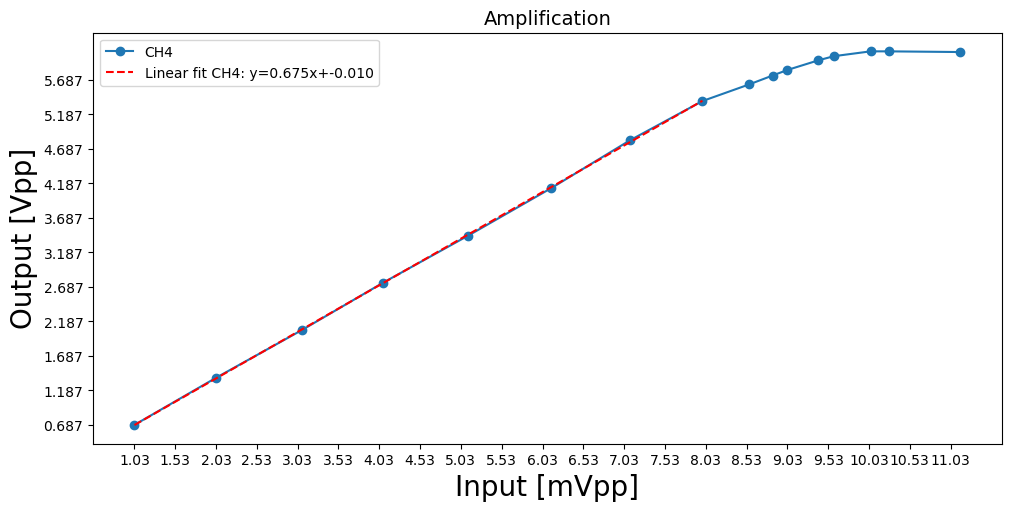

In [76]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

# Perform linear fit on the subset
slope, intercept, r_value, p_value, std_err = stats.linregress(pulse_linear[channel], channel_linear[channel])

# Plot the linear fit on top of the data

# ax.plot(sorted_pulse12, sorted_CH1, '-o', label = 'CH1')
# ax.plot(sorted_pulse12, np.ones_like(sorted_pulse12)*3.14, '--', label = '3.14 [Vpp]')

# ax.plot(sorted_pulse12, sorted_CH2, '-o', label = 'CH2')
# ax.plot(sorted_pulse12, np.ones_like(sorted_pulse12)*6.1, '--', label = '6.1 [Vpp]')

# ax.plot(np.ones_like(sorted_pulse34)*8.5, sorted_CH4, '--')

# ax.plot(sorted_pulse34, sorted_CH3, '-o', label = 'CH3')
ax.plot(sorted_pulse34, sorted_CH4, '-o', label = 'CH4')


ax.plot(pulse_linear[channel], intercept + slope*pulse_linear[channel], 'r--', 
         label=f'Linear fit CH{channel}: y={slope:.3f}x+{intercept:.3f}')

ax.set_title(fr'Amplification', fontsize = 0.7*font_size);
ax.set_xlabel('Input [mVpp]', fontsize = font_size);
ax.set_ylabel(r'Output [Vpp]', fontsize = font_size);

ax.legend(ncol = 1, loc = 'best');



# Manually set more ticks on x and y axis by reducing the interval between them
ax.set_xticks(np.arange(pulse12.min(), pulse12.max(), 0.5));  # Tick every 0.5 units on x-axis
ax.set_yticks(np.arange(CH4.min(), CH4.max(), 0.5));  # Tick every 0.1 units on y-axis

# Print fit results
print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}")